In [170]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPool2D, Flatten, Dense
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Model
from matplotlib import pyplot
from sklearn.metrics import ConfusionMatrixDisplay
from numpy import expand_dims
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# tf.compat.v1.enable_eager_execution()

#### Reading and normalizing data

In [171]:

train = image_dataset_from_directory(
    'Group_24/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    # shuffle=True,
    seed=42,
    validation_split=0.0
)

val = image_dataset_from_directory(
    'Group_24/val/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    # shuffle=True,
    seed=42,
    validation_split=0.0
)

test = image_dataset_from_directory(
    'Group_24/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    # shuffle=True,
    seed=42,
    validation_split=0.0
)
class_names = train.class_names
def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train_data = train.map(normalize)
val_data = val.map(normalize)
test_data = test.map(normalize)

Found 250 files belonging to 5 classes.
Found 50 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


#### Arch 1

In [172]:
input_layer = layers.Input(shape=(224, 224, 3))
conv1 = layers.Conv2D(8, (11, 11), strides=4, padding='same', activation='relu')(input_layer)
max_pool1 = layers.MaxPooling2D((3, 3), strides=(2, 2))(conv1)
conv2 = layers.Conv2D(16, (5, 5), strides=1, padding='same', activation='relu')(max_pool1)
max_pool2 = layers.MaxPooling2D((3, 3), strides=2)(conv2)
flatten = layers.Flatten()(max_pool2)
dense1 = layers.Dense(128, activation='relu')(flatten)
output_layer = layers.Dense(5, activation ='softmax')(dense1)

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=0), optimizer=adam_optimizer, metrics=['accuracy'])

# callbacks
my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10),
    TensorBoard(log_dir=f'./logdir/Q1/Arch1/')
]
# out = model.fit(train_data, validation_data=val_data, epochs=100, callbacks=my_callbacks)
model_fit = model.fit(train_data,validation_data=val_data, batch_size=len(train_data), epochs=100, verbose=0, callbacks=my_callbacks, validation_split=0.0, shuffle=True, validation_batch_size=None)

hist_metric = 'accuracy'
print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
model.save(f'models/Q1/Arch1.tf')


epochs: 13, acc: 1.0



Plotting accuracy

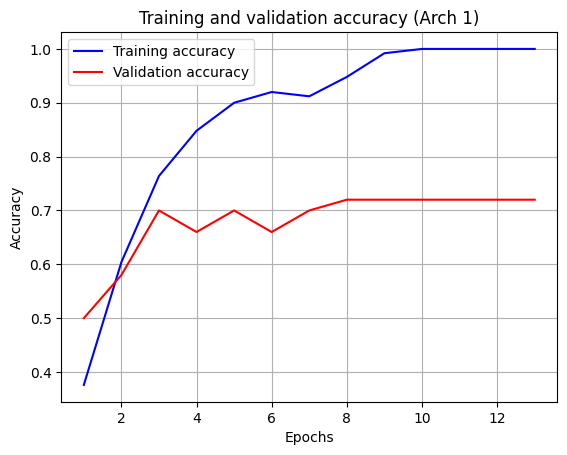

In [173]:
# Plot accuracy history
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy (Arch 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Plotting confusion matrix

In [174]:
# train accuracy and confusion matrix
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1),num_classes=5))
# val accuracy and confusion matrix
val_loss, val_acc = model.evaluate(val_data, verbose=0)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1),num_classes=5))

250/250 [==============================] - 0s 1ms/step
Confusion Matrix:
tf.Tensor(
[[14 11  9  6 10]
 [ 8  9 12  9 12]
 [ 8 10 16  8  8]
 [ 8  7  7 16 12]
 [12 13  6 11  8]], shape=(5, 5), dtype=int32)
50/50 [==============================] - 0s 1ms/step
Confusion Matrix:
tf.Tensor(
[[2 2 1 2 3]
 [0 1 2 5 2]
 [4 2 2 1 1]
 [2 2 3 1 2]
 [3 2 2 1 2]], shape=(5, 5), dtype=int32)


250/250 [==============================] - 0s 1ms/step
50/50 - 0s - loss: 2.0308 - accuracy: 0.7200 - 104ms/epoch - 2ms/step
50/50 [==============================] - 0s 1ms/step
Confusion matrix (train):


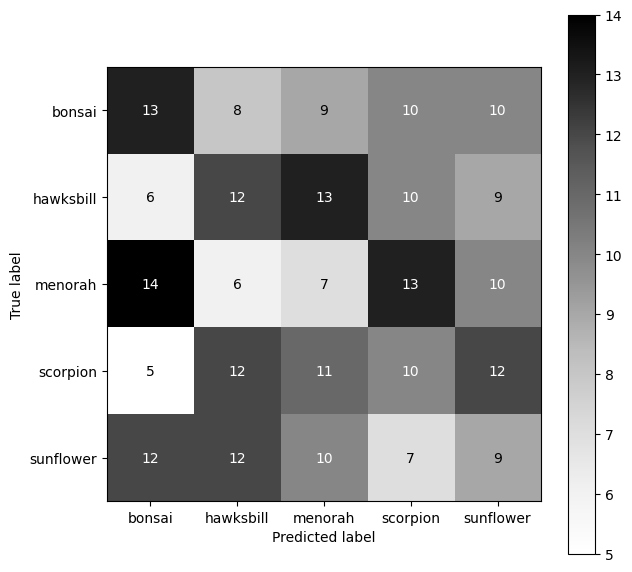

Confusion matrix (val):


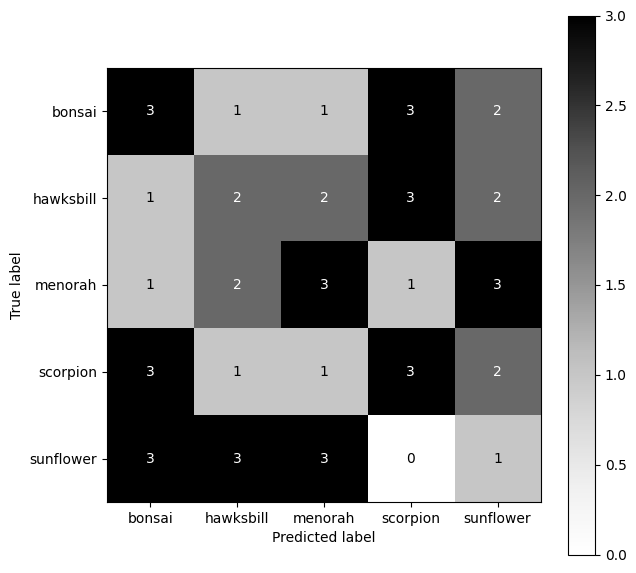

In [175]:
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)

val_loss, val_acc = model.evaluate(val_data, verbose=2)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)

print('Confusion matrix (train):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

print('Confusion matrix (val):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

#### Arch 2

In [176]:
input_layer = layers.Input(shape=(224, 224, 3))
conv1 = layers.Conv2D(8, (11, 11), strides=4, padding='same', activation='relu')(input_layer)
max_pool1 = layers.MaxPooling2D((3, 3), strides=(2, 2))(conv1)
conv2 = layers.Conv2D(16, (5, 5), strides=1, padding='same', activation='relu')(max_pool1)
max_pool2 = layers.MaxPooling2D((3, 3), strides=2)(conv2)
conv3 = layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(max_pool2)
max_pool3 = layers.MaxPooling2D((3,3), strides=2)(conv3)
flatten = layers.Flatten()(max_pool3)
dense1 = layers.Dense(128, activation='relu')(flatten)
output_layer = layers.Dense(5, activation ='softmax')(dense1)

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=0), optimizer=adam_optimizer, metrics=['accuracy'])

# callbacks
my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10),
    TensorBoard(log_dir=f'./logdir/Q1/Arch2/')
]
# out = model.fit(train_data, validation_data=val_data, epochs=100, callbacks=my_callbacks)
model_fit = model.fit(train_data,validation_data=val_data, batch_size=len(train_data), epochs=100, verbose=0, callbacks=my_callbacks, validation_split=0.0, shuffle=True, validation_batch_size=None)

hist_metric = 'accuracy'
print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
model.save(f'models/Q1/Arch2.tf')


epochs: 19, acc: 0.9879999756813049



Plotting accuracy

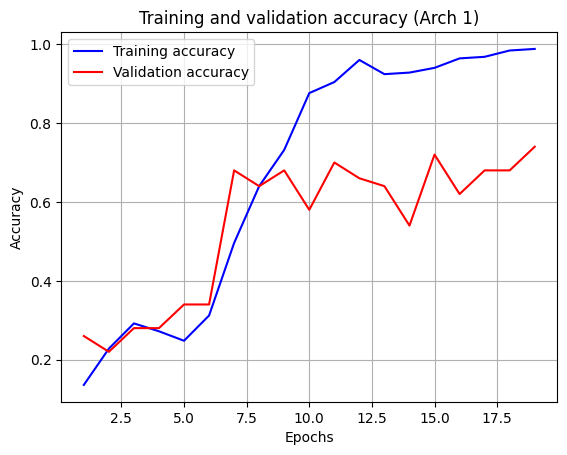

In [177]:
# Plot accuracy history
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy (Arch 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Plotting confusion matrix

In [178]:
# train accuracy and confusion matrix
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1),num_classes=5))
# val accuracy and confusion matrix
val_loss, val_acc = model.evaluate(val_data, verbose=0)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1),num_classes=5))

250/250 [==============================] - 1s 2ms/step
Confusion Matrix:
tf.Tensor(
[[13 14  8  7  8]
 [ 6 15 10  8 11]
 [ 9 10 10 15  6]
 [14  8 11  7 10]
 [ 9  9 10  7 15]], shape=(5, 5), dtype=int32)
50/50 [==============================] - 0s 1ms/step
Confusion Matrix:
tf.Tensor(
[[3 1 2 1 3]
 [2 2 2 3 1]
 [0 4 2 4 0]
 [2 1 2 2 3]
 [1 3 0 2 4]], shape=(5, 5), dtype=int32)


250/250 [==============================] - 0s 2ms/step
50/50 - 0s - loss: 1.6010 - accuracy: 0.7400 - 109ms/epoch - 2ms/step
50/50 [==============================] - 0s 1ms/step
Confusion matrix (train):


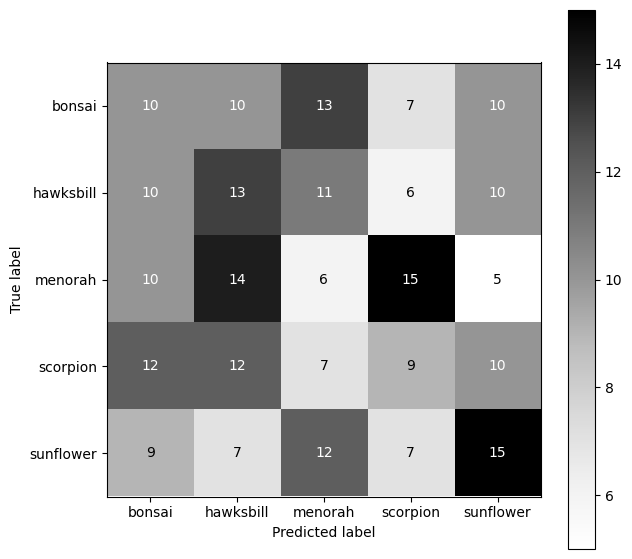

Confusion matrix (val):


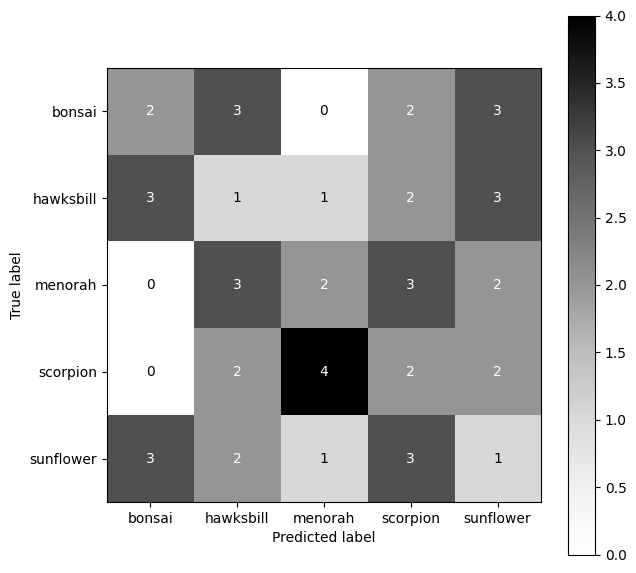

In [179]:
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)

val_loss, val_acc = model.evaluate(val_data, verbose=2)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)

print('Confusion matrix (train):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

print('Confusion matrix (val):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

#### Arch 3

In [180]:
input_layer = layers.Input(shape=(224, 224, 3))
conv1 = layers.Conv2D(8, (11, 11), strides=4, padding='same', activation='relu')(input_layer)
max_pool1 = layers.MaxPooling2D((3, 3), strides=(2, 2))(conv1)
conv2 = layers.Conv2D(16, (5, 5), strides=1, padding='same', activation='relu')(max_pool1)
max_pool2 = layers.MaxPooling2D((3, 3), strides=2)(conv2)
conv3 = layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(max_pool2)
conv4 = layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(conv3)
max_pool3 = layers.MaxPooling2D((3, 3), strides=2)(conv4)
flatten = layers.Flatten()(max_pool3)
dense1 = layers.Dense(128, activation='relu')(flatten)
output_layer = layers.Dense(5, activation ='softmax')(dense1)

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
# model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model = models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=0), optimizer=adam_optimizer, metrics=['accuracy'])

# callbacks
my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10),
    TensorBoard(log_dir=f'./logdir/Q1/Arch3/')
]
# out = model.fit(train_data, validation_data=val_data, epochs=100, callbacks=my_callbacks)
model_fit = model.fit(train_data,validation_data=val_data, batch_size=len(train_data), epochs=100, verbose=0, callbacks=my_callbacks, validation_split=0.0, shuffle=True, validation_batch_size=None)

hist_metric = 'accuracy'
print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
model.save(f'models/Q1/Arch3.tf')


epochs: 18, acc: 0.2879999876022339



Plotting accuracy

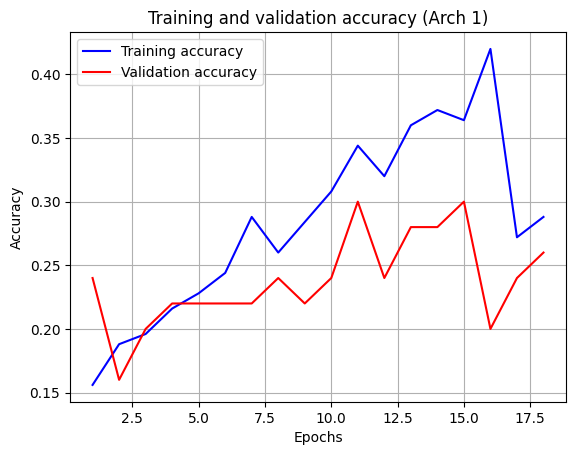

In [181]:
# Plot accuracy history
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy (Arch 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Plotting confusion matrix

In [182]:
# train accuracy and confusion matrix
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1),num_classes=5))
# val accuracy and confusion matrix
val_loss, val_acc = model.evaluate(val_data, verbose=0)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)
print("Confusion Matrix:")
print(tf.math.confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1),num_classes=5))

250/250 [==============================] - 1s 2ms/step
Confusion Matrix:
tf.Tensor(
[[ 4 41  1  3  1]
 [ 3 37  3  4  3]
 [ 6 39  1  4  0]
 [ 3 36  1  7  3]
 [ 4 31  3  3  9]], shape=(5, 5), dtype=int32)
50/50 [==============================] - 0s 2ms/step
Confusion Matrix:
tf.Tensor(
[[0 9 0 1 0]
 [0 9 0 1 0]
 [0 7 1 2 0]
 [1 5 2 0 2]
 [0 7 1 1 1]], shape=(5, 5), dtype=int32)


250/250 [==============================] - 1s 2ms/step
50/50 - 0s - loss: 2.0218 - accuracy: 0.2600 - 129ms/epoch - 3ms/step
50/50 [==============================] - 0s 2ms/step
Confusion matrix (train):


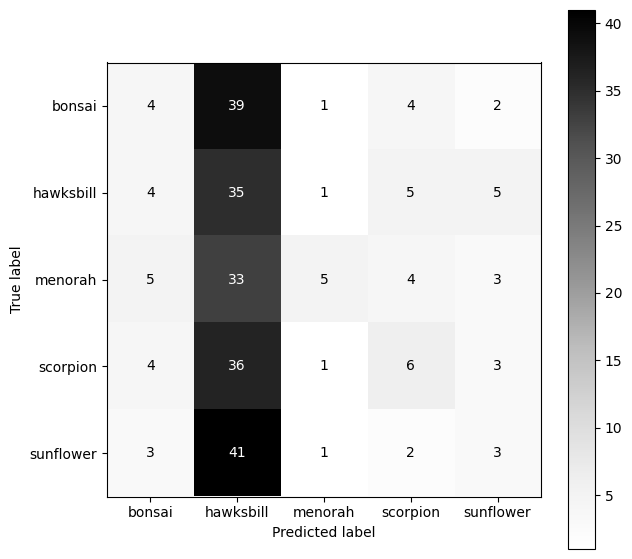

Confusion matrix (val):


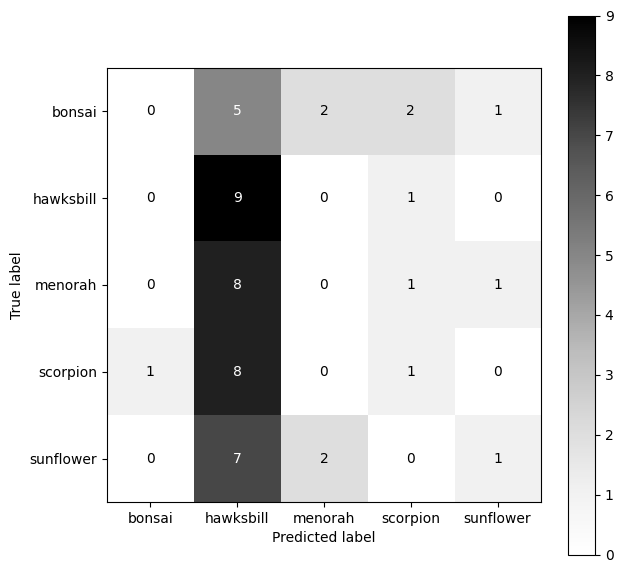

In [183]:
train_loss, train_acc = model.evaluate(train_data, verbose=0)
train_pred = model.predict(train_data)
train_labels = tf.concat([q for p, q in train_data], axis=0)

val_loss, val_acc = model.evaluate(val_data, verbose=2)
val_pred = model.predict(val_data)
val_labels = tf.concat([q for p, q in val_data], axis=0)

print('Confusion matrix (train):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(train_labels,axis=1),tf.argmax(train_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

print('Confusion matrix (val):')
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(tf.argmax(val_labels,axis=1),tf.argmax(val_pred,axis=1)), display_labels=class_names)
cm_display.plot(ax = ax, cmap='Greys', colorbar=True)
plt.show()

#### Feature maps for best architecture

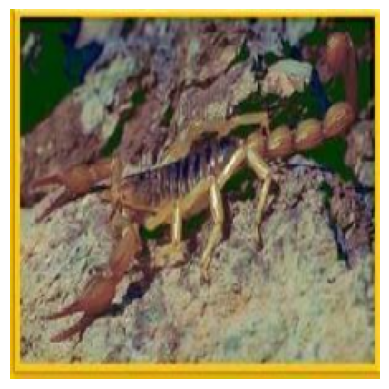

In [184]:
image = [image.numpy() for image, label in train_data.take(1)][0]
plt.imshow(image[0])
plt.axis(False)
plt.show()

#### Maximally activating patch

In [185]:
def get_image(image_path):
    # Load and decode image file
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Convert image to float32 tensor and normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0

    # Reshape image tensor to match model input shape
    image = tf.image.resize(image, [224, 224])

    # Add batch dimension to image tensor
    image = tf.expand_dims(image, 0)
    return image


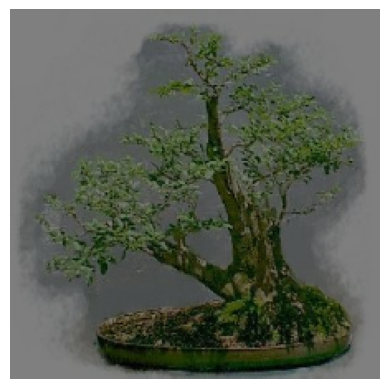

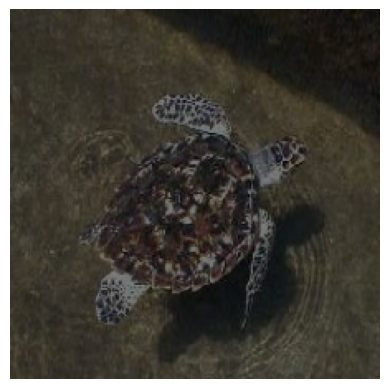

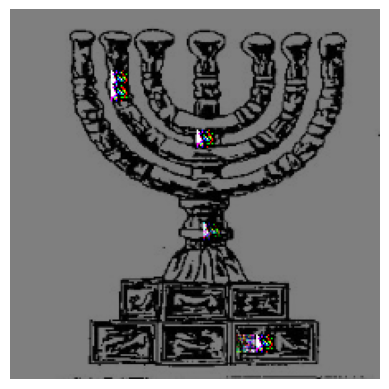

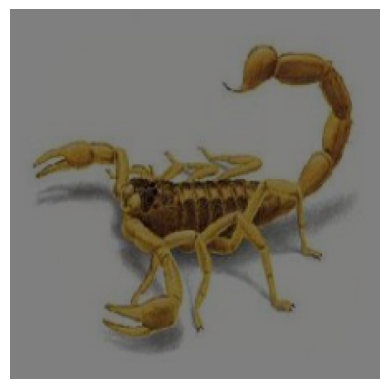

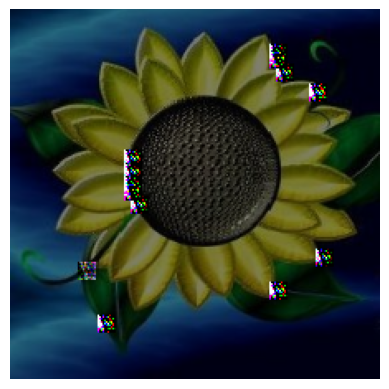

In [194]:
image_paths = ["Group_24/train/bonsai/image_0060.jpg","Group_24/train/hawksbill/image_0058.jpg","Group_24/train/menorah/image_0004.jpg","Group_24/train/scorpion/image_0005.jpg","Group_24/train/sunflower/image_0018.jpg"]

for path in image_paths:
    part_model = Model(inputs=model.inputs, outputs=model.layers[5].output)
    image = get_image(path)
    x = tf.constant(image)

    with tf.GradientTape() as tape:
        tape.watch(x)
        hidden_output = part_model(x)
        max_neuron_index = tf.math.argmax(hidden_output, axis=-1)
        neuron_output = tf.gather(hidden_output, max_neuron_index, axis=-1)


    # Calculate gradients with respect to every trainable variable
    grad = tape.gradient(neuron_output,x)
    # print(grad)
    alpha = 0.5
    masked_img = alpha * image[0] + (1 - alpha) * grad[0]
    plt.imshow(masked_img)
    plt.axis("off")
    plt.show()
